In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigcode/digit-bytelevel-bpe-jss-v1.1-49152", use_auth_token=True, slow=True)

/opt/conda/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds_py = load_dataset("bigcode/the-stack-smol", data_dir="data/python", use_auth_token=True, split="train")
ds_js = load_dataset("bigcode/the-stack-smol", data_dir="data/javascript", use_auth_token=True, split="train")
ds_java = load_dataset("bigcode/the-stack-smol", data_dir="data/java", use_auth_token=True, split="train")

Using custom data configuration bigcode--the-stack-smol-7b51f8bde3058781
Found cached dataset json (/home/loubna_huggingface_co/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--the-stack-smol-848a30ee7bac5c92
Found cached dataset json (/home/loubna_huggingface_co/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-848a30ee7bac5c92/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Using custom data configuration bigcode--the-stack-smol-95a2b7de57a7cb35
Found cached dataset json (/home/loubna_huggingface_co/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-95a2b7de57a7cb35/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


In [3]:
# load KenLM
import kenlm

kenlm_path = "/home/loubna_huggingface_co/bigcode-analysis/kenlm_data/gram.binary"
model = kenlm.LanguageModel(kenlm_path)

In [4]:
model

<Model from b'gram.binary'>

In [59]:
def perplexity(examples):
    """convert the content of each file into one line after tokenization and compute perplexity
    source: https://github.com/facebookresearch/cc_net/blob/
    bda555bd1cf1ee2e0b925363e62a61cd46c8b60d/cc_net/tools/expand_corpus.py#L116"""
    tokenized_content = tokenizer(examples["content"])
    lines = []
    lengths = []
    ppls = []
    for input_ids in tokenized_content.input_ids:
        pieces = tokenizer.convert_ids_to_tokens(input_ids)
        line = (" ".join(pieces))
        log_score = model.score(line)
        pp_score = 10.0 ** (-log_score / len(pieces))
        pp_score = round(pp_score, 1)
        lines.append(line)
        lengths.append(len(pieces))
        ppls.append(pp_score)
    return {"content_ppl": lines, "length": lengths, "perplexity": ppls}

In [60]:
examples = ['def count_lines(filename):\n    with open(filename, "r") as file:\n \
            count = 0\n        for line in file:\n            count += 1\n    return count', \
            'def is_in_list(L, e):\n    """Find if list L contains the element e."""\n    return e in L', \
            'We can use KenLM to train a trigram language model with Kneser-Ney smoothing with the following commands',\
            'https://github.com/bigcode-project/bigcode-analysis', \
            'hsbysht汉字测试这是一个测试 sell flowers:', 'x12x34c56,C67,VG(65FVDDGVNJ defdefedefsbs',]
contents = {"content": examples}

In [61]:
contents = perplexity(contents)

In [62]:
contents

{'content_ppl': ['def Ġcount _ lines ( filename ): ĊĠĠĠ Ġwith Ġopen ( filename , Ġ" r ") Ġas Ġfile : ĊĠĠĠĠĠĠĠĠĠĠĠĠ Ġcount Ġ= Ġ 0 ĊĠĠĠĠĠĠĠ Ġfor Ġline Ġin Ġfile : ĊĠĠĠĠĠĠĠĠĠĠĠ Ġcount Ġ+= Ġ 1 ĊĠĠĠ Ġreturn Ġcount',
  'def Ġis _ in _ list ( L , Ġe ): ĊĠĠĠ Ġ""" Find Ġif Ġlist ĠL Ġcontains Ġthe Ġelement Ġe .""" ĊĠĠĠ Ġreturn Ġe Ġin ĠL',
  'We Ġcan Ġuse ĠK en LM Ġto Ġtrain Ġa Ġtr igram Ġlanguage Ġmodel Ġwith ĠK nes er - N ey Ġsmoothing Ġwith Ġthe Ġfollowing Ġcommands',
  'https :// github . com / big code - project / big code - analysis',
  'hs b ys ht æ± ī åŃĹ æµĭè¯ķ è¿Ļ æĺ¯ä¸Ģä¸ª æµĭè¯ķ Ġsell Ġflow ers :',
  'x 1 2 x 3 4 c 5 6 , C 6 7 , VG ( 6 5 FV DD GV NJ Ġdef def e defs bs'],
 'length': [38, 27, 25, 15, 15, 27],
 'perplexity': [13.0, 348.7, 339.8, 574.6, 8053.7, 2683.5]}

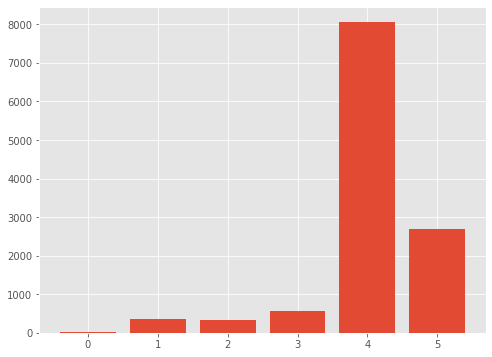

In [66]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))

plt.bar(np.arange(6), contents["perplexity"])
plt.show()

## Python

In [67]:
ds_ppl = ds_py.map(perplexity, batched=True, batch_size=1000)

100%|███████████████████████████████████████████| 10/10 [00:33<00:00,  3.36s/ba]


In [68]:
import numpy as np

# get stats for peprlexity
print(f"Mean perplexity : {np.mean(ds_ppl['perplexity']):.2f}")
print(f"Median perplexity: {np.median(ds_ppl['perplexity']):.2f}")
print(f"Min perplexity: {np.min(ds_ppl['perplexity']):.2f}")
print(f"Max perplexity: {np.max(ds_ppl['perplexity']):.2f}")
print(f"Percentiles of perplexity  60th, 80th, 90th, 95th, 99th: {np.round(np.percentile(ds_ppl['perplexity'], [60, 80, 90, 95, 99]), 2)}")

Mean perplexity : 4.74
Median perplexity: 4.60
Min perplexity: 1.30
Max perplexity: 389.30
Percentiles of perplexity  60th, 80th, 90th, 95th, 99th: [4.9 5.7 6.3 7.  9.8]


In [81]:
ds_high_ppl = ds_ppl.filter(lambda x: x['perplexity'] > 7)
print(f"percentage samples with perplexity > 7: {len(ds_high_ppl)*100/len(ds_ppl)}")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.34ba/s]

percentage samples with perplexity > 7: 4.88


In [82]:
ds_high_ppl

Dataset({
    features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang', 'content_ppl', 'length', 'perplexity'],
    num_rows: 488
})

In [83]:
print(ds_high_ppl[0]["content"])

import hashlib

from fastecdsa import keys, curve, ecdsa
from hashlib import sha256
from uuid import uuid4


class Transaction:
    def __init__(self, from_address, to_address, amount):
        self.from_address = from_address
        self.to_address = to_address
        self.amount = amount
        self.id = str(uuid4()).replace('-', '')
        self.signature = None

    def calculate_hash(self):
        return sha256((str(self.from_address) + str(self.to_address) + str(self.amount) + self.id).encode()).hexdigest()

    def sign_tx(self, priv_key):
        hash_tx = self.calculate_hash()
        self.signature = ecdsa.sign(hash_tx, priv_key, hashfunc=sha256)

    def is_valid(self):
        if self.signature is None:
            return True
        if len(self.signature) == 0 and self.to_address is None:
            return False
        hash_tx = self.calculate_hash()
        pubkey = keys.get_public_keys_from_sig(self.signature, hash_tx, curve=curve.P256, hashfunc=sha256)
        va

In [84]:
print(ds_high_ppl[1]["content"])

def number_of_occurrences(s, xs):
    return xs.count(s)


In [85]:
print(ds_high_ppl[2]["content"])

#Python program to get the size of an object in bytes
import sys
Object = input("Enter any object: ")

print(f'The size of the object {Object} is {sys.getsizeof(Object)} bytes')



In [86]:
print(ds_high_ppl[3]["content"])

from .chain import *
from .element import *



In [87]:
print(ds_high_ppl[12]["content"])

def dif(x, y):
    q = 0
    for i in range(len(x)):
        if x[i] != y[i]: q += 1
    return q

e = str(input())
n = int(input())
v = []
for i in range(5): v.append(dif(e, str(input())))
if min(v) > n: print(-1)
else:
    print(v.index(min(v))+1)
    print(min(v))



In [75]:
ds_vhigh_ppl = ds_ppl.filter(lambda x: x['perplexity'] > 20)
print(f"percentage samples with perplexity > 20: {len(ds_vhigh_ppl)*100/len(ds_ppl)}")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.61ba/s]

percentage samples with perplexity > 20: 0.19


In [76]:
ds_vhigh_ppl

Dataset({
    features: ['content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'licenses', 'repository_name', 'path', 'size', 'lang', 'content_ppl', 'length', 'perplexity'],
    num_rows: 19
})

In [77]:
print(ds_vhigh_ppl[0]["content"])

df['A']

#         A
# ---------
# -0.613035
# -1.265520
#  0.763851
# -1.248425
#  2.105805
#  1.763502
# -0.781973
#  1.400853
# -0.746025
# -1.120648
# 
# [100 rows x 1 column]


In [78]:
print(ds_vhigh_ppl[1]["content"])

from .gui import *


In [79]:
print(ds_vhigh_ppl[2]["content"])

class Action():
    ()



In [80]:
print(ds_vhigh_ppl[3]["content"])

#for fixture loading



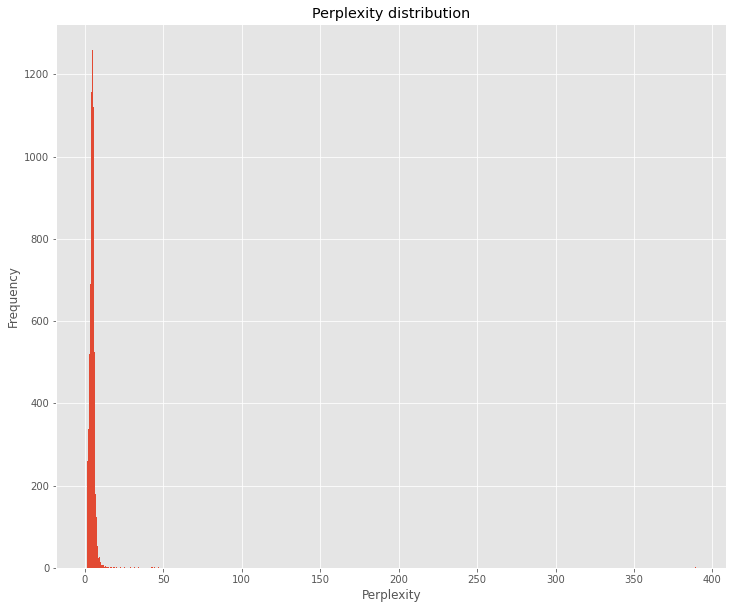

In [88]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
# plot hist of perplexity
plt.hist(ds_ppl['perplexity'], bins=1000)
plt.title("Perplexity distribution")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.show()

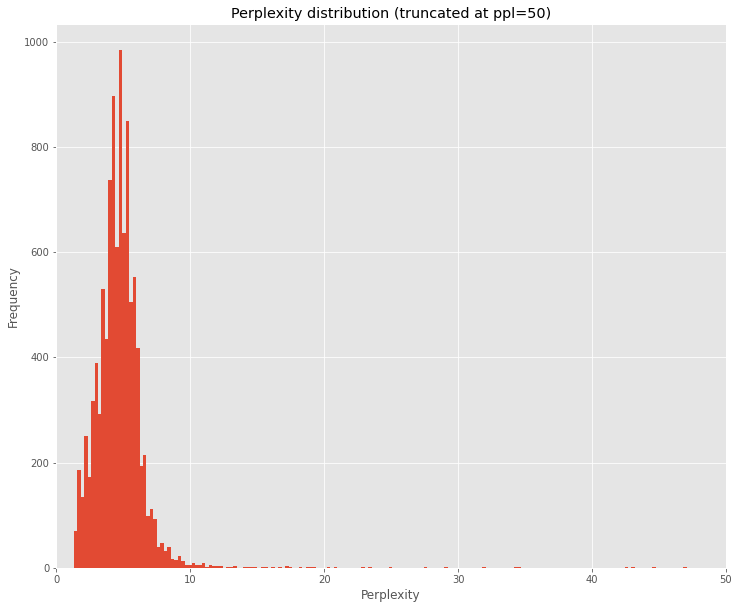

In [89]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
# plot hist of perplexity
plt.hist(ds_ppl['perplexity'], bins=1500)
plt.xlim(0, 50)
plt.title("Perplexity distribution (truncated at ppl=50)")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.show()

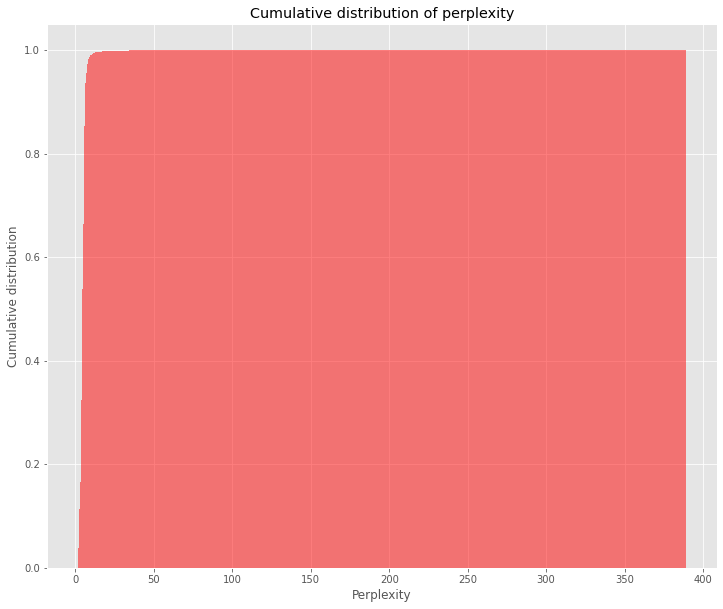

In [90]:
# plot different percentiles from 10 to 99
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.hist(ds_ppl['perplexity'], bins=1000, color="#FF0000", alpha=0.5, density=True, cumulative=True)
#plt.xticks(np.arange(0, 2000, 200))
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Perplexity")
plt.ylabel("Cumulative distribution")
plt.title("Cumulative distribution of perplexity")
plt.show()

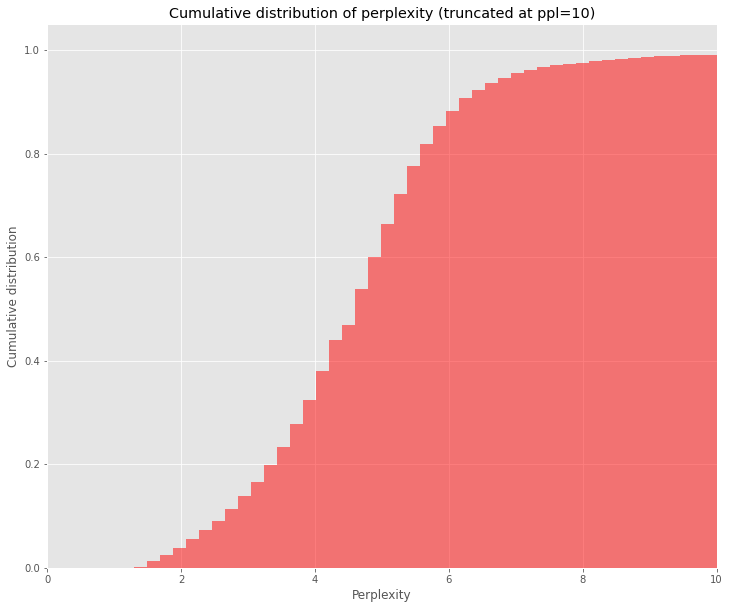

In [91]:
# plot different percentiles from 10 to 99
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 10))
plt.hist(ds_ppl['perplexity'], bins=2000, color="#FF0000", alpha=0.5, density=True, cumulative=True)
plt.xlim(0, 10)
plt.xlabel("Perplexity")
plt.ylabel("Cumulative distribution")
plt.title("Cumulative distribution of perplexity (truncated at ppl=10)")
plt.show()